In [16]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor, BaggingClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, \
f1_score, log_loss, classification_report, roc_curve, auc, roc_auc_score, r2_score

import matplotlib.pyplot as plt
import datetime

import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings("ignore")

In [17]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

Это набор данных из одного банка в Соединенных Штатах. Помимо обычных услуг, этот банк также предоставляет услуги по страхованию автомобилей. Банк регулярно организует кампании по привлечению новых клиентов. У банка есть данные потенциальных клиентов, и сотрудники банка звонят им для рекламы доступных вариантов страхования автомобилей. Нам предоставляется общая информация о клиентах (возраст, работа и т.д.), А также более конкретная информация о текущей кампании по продаже страховых услуг (общение, последний день контакта) и предыдущих кампаниях (такие атрибуты, как предыдущие попытки, результат).
У вас есть данные о 4000 клиентах, с которыми связывались во время последней кампании и для которых известны результаты кампании (купил клиент страховку или нет).

Задача состоит в том, чтобы предсказать для 1000 клиентов, с которыми связались во время текущей кампании, будут ли они покупать страховку автомобиля или нет.


**Атрибуты**:

- Id - уникальный идентификатор клиента
- Age - Возраст
- Job - Работа
- Marital - Семейное положение
- Education - Образование
- Default - Имеет ли кредит по умолчанию?
- Balance - Среднегодовой баланс, в долларах США
- HHInsurance - Застраховано ли домашнее хозяйство
- CarLoan - Имеет ли клиент автокредит
- Communication - Тип контактной связи
- LastContactDay - День последнего контакта
- LastContactMonth - Месяц последнего контакта
- NoOfContacts - Количество контактов, выполненных в ходе этой кампании для данного клиента
- DaysPassed - Количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании (числовое значение; -1 означает, что с клиентом ранее не связывались)
- PrevAttempts - Количество контактов, выполненных до этой кампании и для данного клиента
- Outcome - Результаты предыдущей маркетинговой кампании
- CallStart - Время начала последнего звонка
- CallEnd - Время конца последнего звонка
- CarInsurance - Оформил ли клиент страховку автомобиля?

In [18]:
df = pd.read_csv('carInsurance_train.csv')

In [19]:
df.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


Вывести информацию о датасете

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

In [21]:
df.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [22]:
df.describe(include= 'object')

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,10:42:44,10:52:24
freq,893,2304,1988,2831,1049,437,3,3


Не взяли страховку  59.9 %
Дисбаланс есть, но не значимый 


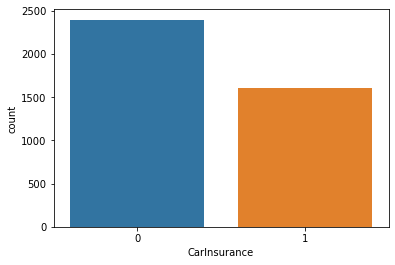

In [23]:
sns.countplot(x = 'CarInsurance', data= df)
print('Не взяли страховку ',(df[df.CarInsurance == 0]['CarInsurance'].count()/df.CarInsurance.count())*100,'%')
print('Дисбаланс есть, но не значимый ')

Создаем новый признак call_duration - длительность последнего звонка

In [24]:
pseconds = lambda hms:sum(map(lambda a,b: int(a)*b,hms.split(':'),(3600,60,1)))
for i in range(len(df['CallEnd'])):
    df['CallEnd'][i] = pseconds(df['CallEnd'][i])
for i in range(len(df['CallStart'])):
    df['CallStart'][i] = pseconds(df['CallStart'][i])

In [26]:
df['call_durationа'] = df['CallEnd'] - df['CallStart']

Проверяем, есть ли пропуски? Если есть заполните 'None' - дляя object и медианой для числовых данных

In [27]:
df.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
call_durationа         0
dtype: int64

In [28]:
df= df.fillna('None')

Целевая переменная CarInsurance

In [29]:
df = pd.get_dummies(df, columns=['Job','Marital','Education','Communication','Outcome','LastContactMonth'])
del df['Id']

In [30]:
X = df.drop(['CarInsurance'], axis=1)
y = df['CarInsurance']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, stratify=y, random_state=10)

1) Обучаем простой BaggingClassifier и RandomForestlassifier

2) Сравниваем результаты по метрикам

3) Строим для каждого ROC-AUC


# BaggingClassifier

In [31]:
bgc = BaggingClassifier()
bgc.fit(X_train, y_train)

BaggingClassifier()

In [32]:
y_pred = bgc.predict(X_test)
y_score = bgc.predict_proba(X_test)[:,1:]

print('roc-auc:', roc_auc_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.8043601347216267
precision: 0.7797927461139896
recall: 0.7506234413965087
f1: 0.7649301143583227
logloss: 6.389741598840043


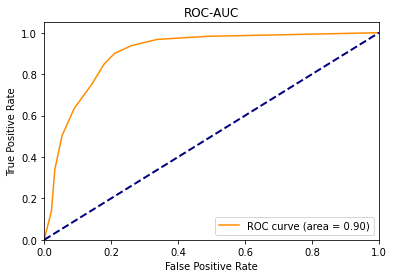

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, bgc.predict_proba(X_test)[:,1:])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

# RandomForestlassifier 

In [34]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [35]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)[:,1:]

print('roc-auc:', roc_auc_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.836408561234643
precision: 0.8153846153846154
recall: 0.7930174563591023
f1: 0.8040455120101139
logloss: 5.35356791222613


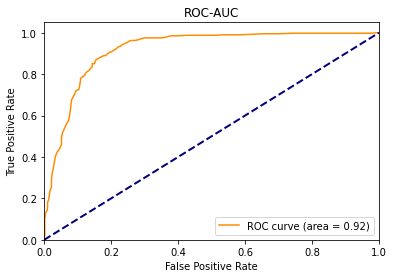

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

Выберем лучший бейзлайн (алгоритм) и найдем лучшие параметры помощи Gridsearch 



In [37]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 100, None],
    'min_samples_leaf': [1, 2, 3],
    'class_weight':['balanced',False]
}

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)


In [38]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=1; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=1; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=1; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=2; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=2; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=2; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=3; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=3; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, min_samples_leaf=3; total time=   0.1s
[CV] END bootstrap=True, clas

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', False],
                         'max_depth': [10, 100, None],
                         'min_samples_leaf': [1, 2, 3]},
             verbose=2)

In [40]:
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:,1:]

print('roc-auc:', roc_auc_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.8471663079363362
precision: 0.7962085308056872
recall: 0.8379052369077307
f1: 0.8165249088699879
logloss: 5.21542400101051


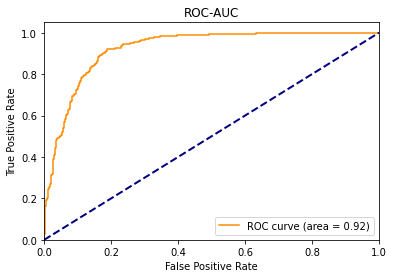

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

In [257]:
grid_search.best_score_

0.8396666666666666

In [258]:
perm = PermutationImportance(grid_search, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.2753 ± 0.0078,call_durationа
0.0474 ± 0.0099,HHInsurance
0.0291 ± 0.0025,Age
0.0272 ± 0.0035,LastContactDay
0.0271 ± 0.0039,Balance
0.0251 ± 0.0038,Communication_None
0.0171 ± 0.0032,CallEnd
0.0169 ± 0.0020,CallStart
0.0163 ± 0.0018,Communication_cellular
0.0153 ± 0.0028,NoOfContacts
